In [17]:
import sys
sys.path.append("/home/hugo/projetos-doutorado/Appliance-Energy-Prediction")
import pandas as pd
from pca_fts.PcaWeightedMVFTS import PcaWeightedMVFTS
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt
from pyFTS.common import Util
import datetime
import statistics
import math
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Aux functions

In [18]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [19]:
# # convert series to supervised learning
# def series_to_supervised_miso(data, n_in, n_out, endog_var='Appliances', dropnan=True):
# 	"""
# 	Frame a time series as a supervised learning dataset.
# 	Arguments:
# 		data: Sequence of observations as a list or NumPy array.
# 		n_in: Number of lag observations as input (X).
# 		n_out: Number of observations as output (y).
# 		dropnan: Boolean whether or not to drop rows with NaN values.
# 	Returns:
# 		Pandas DataFrame of series framed for supervised learning.
# 	"""
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = pd.DataFrame(data)
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df[endog_var].shift(-i))
# 		if i == 0:
# 			names += [(endog_var+'(t)')]
# 		else:
# 			names += [(endog_var+'(t+%d)' % (i))]
# 	# put it all together
# 	agg = pd.concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg

In [20]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

## Dataset Smart Home with Weather Information

In [21]:
df = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/HomeC.csv')
data = df.drop(labels=['icon','summary','cloudCover', 'House overall [kW]', 'time'], axis=1)
data = data.loc[0: : 10]
data
data.dropna(inplace=True)
data = clean_dataset(data)
data.head()

/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
0,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
10,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
20,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
30,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
40,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0


In [22]:
round(data.describe(),3)

,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
count,50391.000,50391.000,50391.000,50391.000,50391.000,50391.000,50391.000,50391.000,50391.000,50391.000,...,50391.000,50391.000,50391.000,50391.000,50391.000,50391.000,50391.000,50391.000,50391.000,50391.000
mean,0.860,0.076,0.031,0.099,0.138,0.081,0.064,0.042,0.014,0.003,...,50.742,0.664,9.253,48.264,1016.302,6.649,202.390,0.003,38.693,0.056
std,1.058,0.129,0.190,0.168,0.180,0.104,0.077,0.058,0.012,0.024,...,19.115,0.194,1.612,22.030,7.895,3.982,106.544,0.011,19.088,0.166
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-12.640,0.130,0.270,-32.080,986.400,0.000,0.000,0.000,-27.240,0.000
25%,0.370,0.003,0.000,0.020,0.065,0.040,0.005,0.007,0.013,0.000,...,35.770,0.510,9.420,31.090,1011.290,3.660,148.000,0.000,24.600,0.000
50%,0.564,0.004,0.000,0.021,0.067,0.042,0.005,0.008,0.013,0.001,...,50.320,0.680,10.000,50.320,1016.530,5.930,208.000,0.000,39.030,0.000
75%,0.974,0.084,0.000,0.069,0.081,0.069,0.125,0.052,0.013,0.001,...,66.255,0.840,10.000,66.255,1021.480,8.940,295.000,0.000,54.790,0.000
max,12.819,0.591,1.400,1.880,0.795,0.734,0.786,1.229,1.014,0.916,...,93.720,0.980,10.000,101.120,1042.460,22.910,359.000,0.191,75.490,0.840


### Dataset Smart Home with Weather Information: Preprocessing, Lag = 1, t+1

In [23]:
# data = series_to_supervised_miso(data, 1, 1, endog_var='use [kW]', dropnan=True)
# data.head()

In [24]:
# round(data.describe(),3)

## Model: PcaWeightedMVFTS - PCA-MVFTS

In [25]:
pca_wmvfts = PcaWeightedMVFTS(n_components = 2,
                       endogen_variable = 'use [kW]',
                       n_part = 50)

--------------------
training window 0
[ 17:31:54] getting statistics


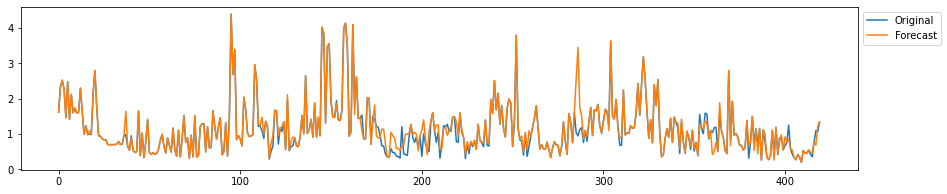

--------------------
training window 1679
[ 17:32:01] getting statistics


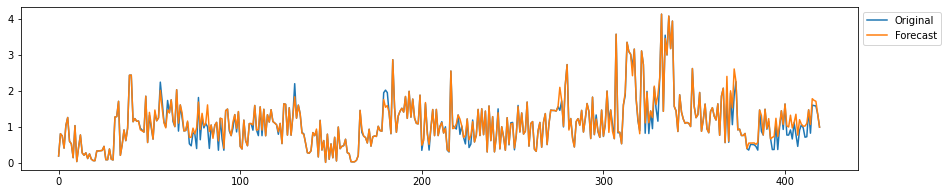

--------------------
training window 3358
[ 17:32:08] getting statistics


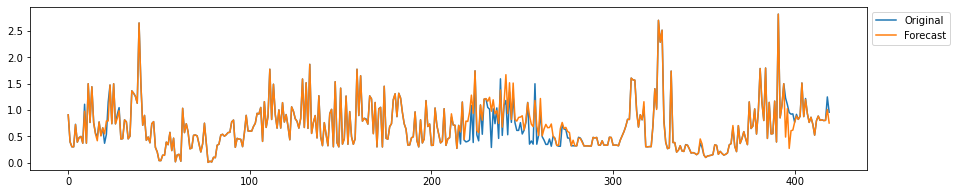

--------------------
training window 5037
[ 17:32:15] getting statistics


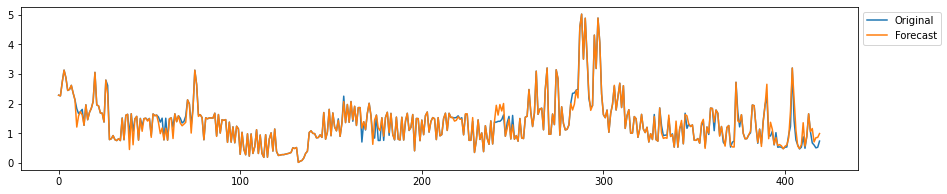

--------------------
training window 6716
[ 17:32:22] getting statistics


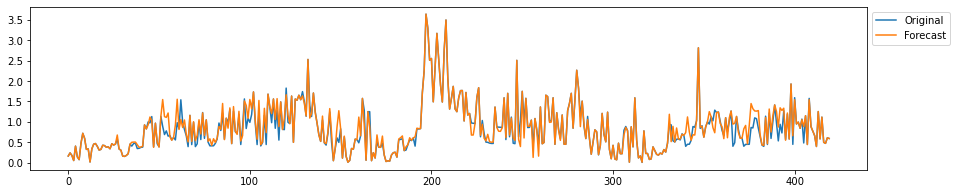

--------------------
training window 8395
[ 17:32:28] getting statistics


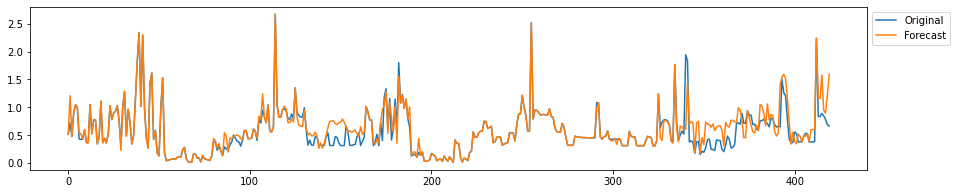

--------------------
training window 10074
[ 17:32:33] getting statistics


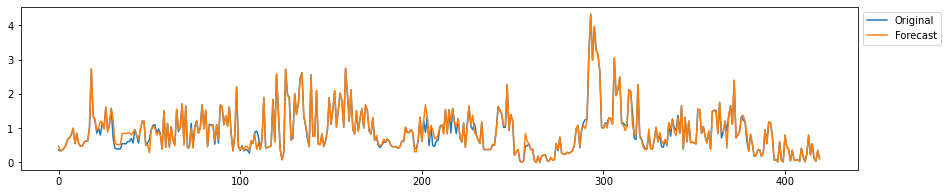

--------------------
training window 11753
[ 17:32:38] getting statistics


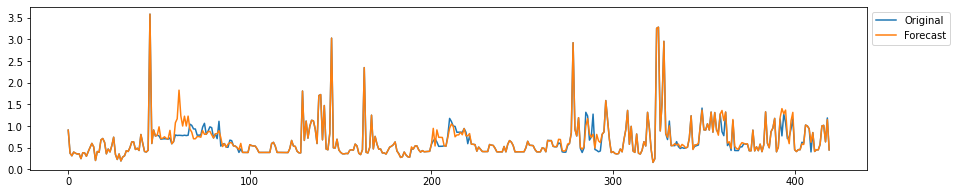

--------------------
training window 13432
[ 17:32:44] getting statistics


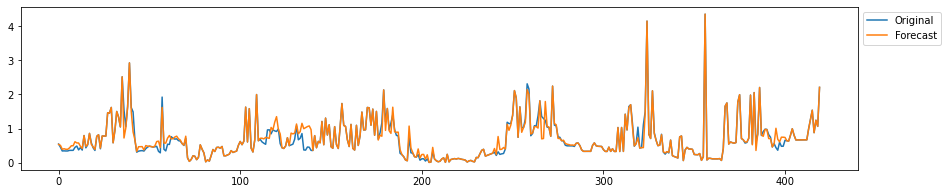

--------------------
training window 15111
[ 17:32:51] getting statistics


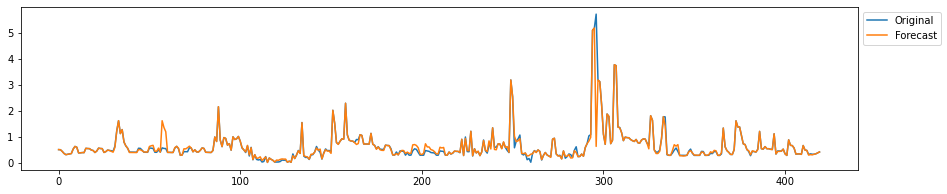

--------------------
training window 16790
[ 17:32:56] getting statistics


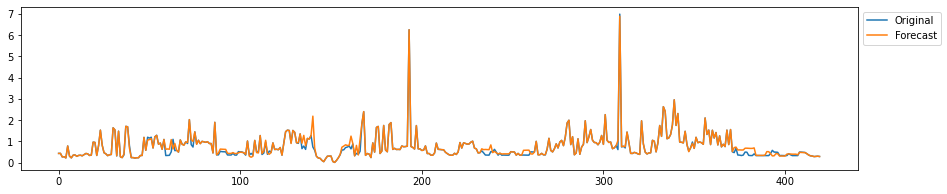

--------------------
training window 18469
[ 17:33:02] getting statistics


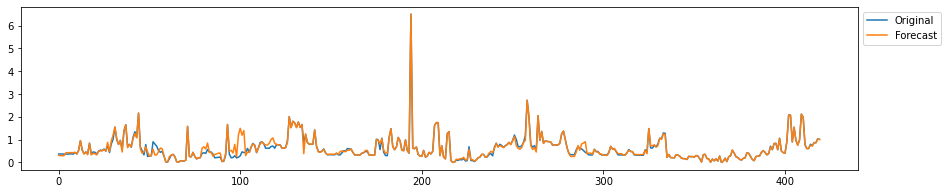

--------------------
training window 20148
[ 17:33:08] getting statistics


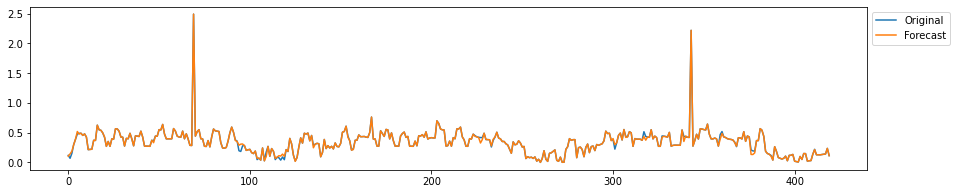

--------------------
training window 21827
[ 17:33:14] getting statistics


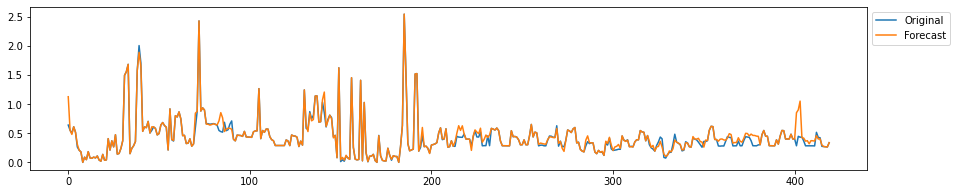

--------------------
training window 23506
[ 17:33:20] getting statistics


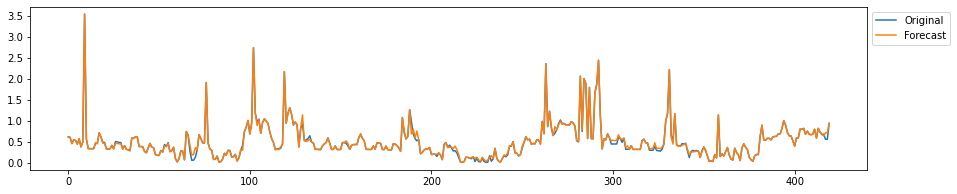

--------------------
training window 25185
[ 17:33:26] getting statistics


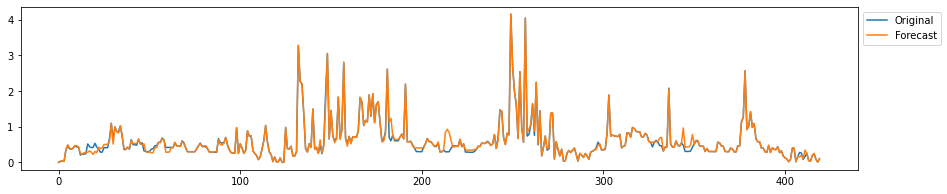

--------------------
training window 26864
[ 17:33:32] getting statistics


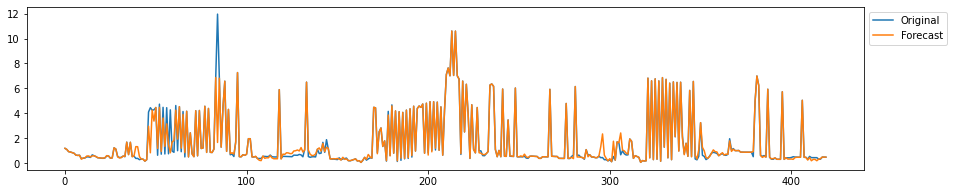

--------------------
training window 28543
[ 17:33:38] getting statistics


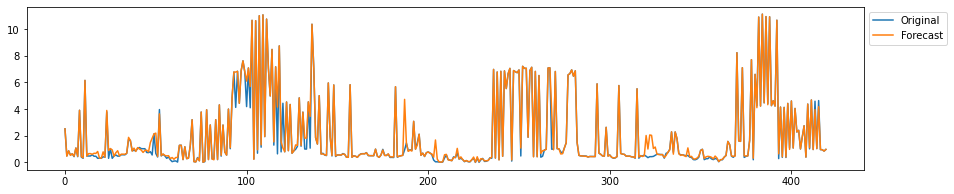

--------------------
training window 30222
[ 17:33:44] getting statistics


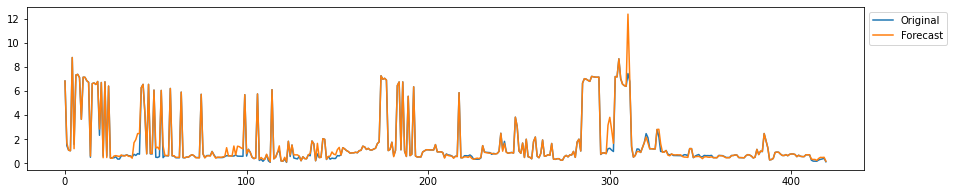

--------------------
training window 31901
[ 17:33:51] getting statistics


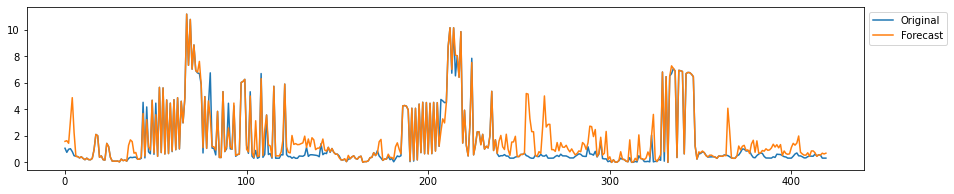

--------------------
training window 33580
[ 17:33:57] getting statistics


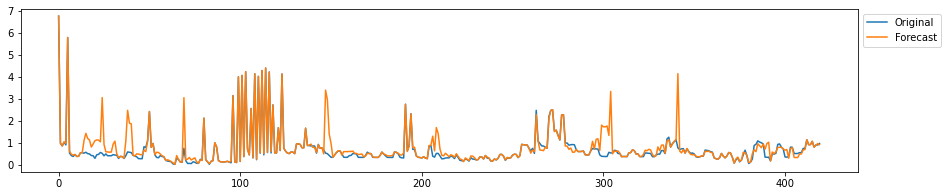

--------------------
training window 35259
[ 17:34:03] getting statistics


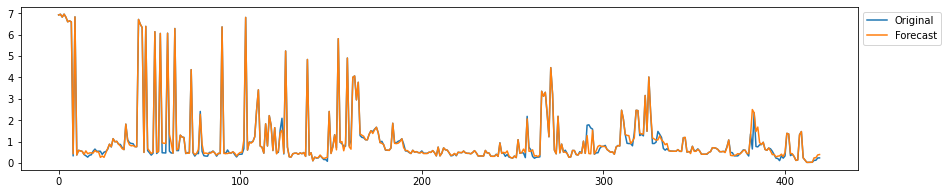

--------------------
training window 36938
[ 17:34:10] getting statistics


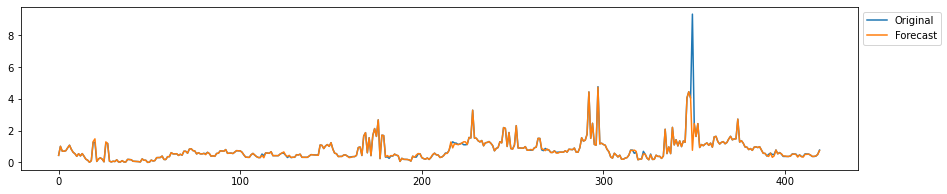

--------------------
training window 38617
[ 17:34:17] getting statistics


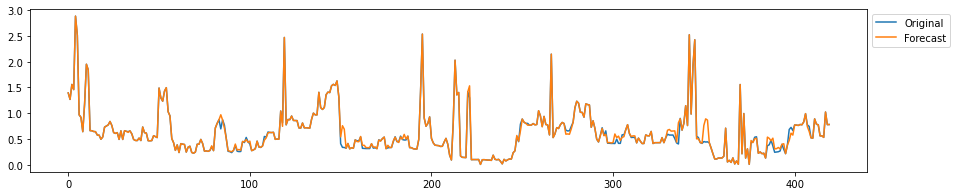

--------------------
training window 40296
[ 17:34:23] getting statistics


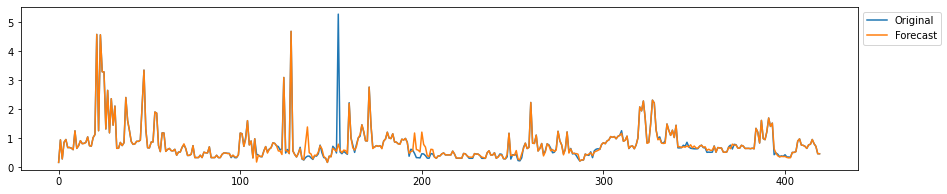

--------------------
training window 41975
[ 17:34:29] getting statistics


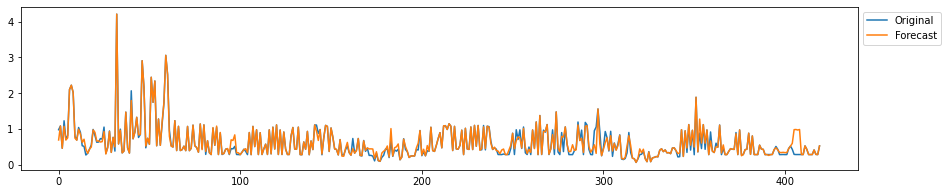

--------------------
training window 43654
[ 17:34:35] getting statistics


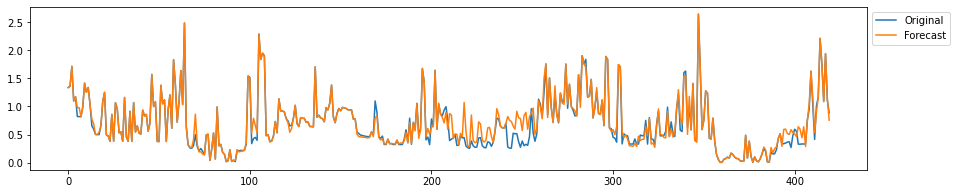

--------------------
training window 45333
[ 17:34:42] getting statistics


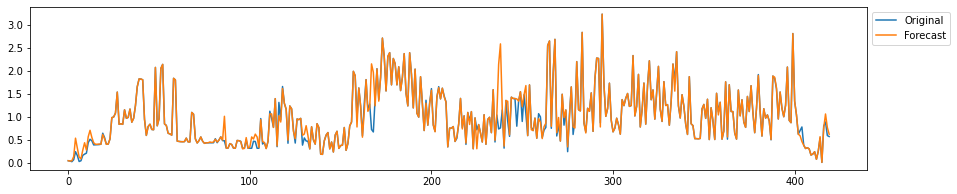

--------------------
training window 47012
[ 17:34:48] getting statistics


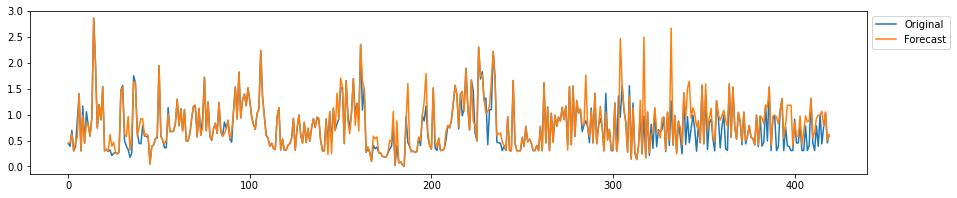

--------------------
training window 48691
[ 17:34:54] getting statistics


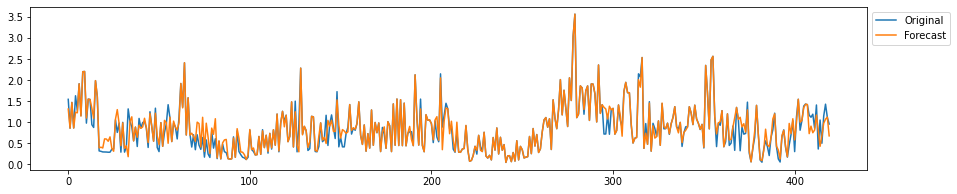

In [26]:
result = {
     "window": [],
     "rmse": [],
     "mape": [],
     "smape": [],
     "mae": []
}

order = 1
tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        #data_train = ttrain.loc[:,'use [kW]':'precipProbability']
        #data_test = ttest.loc[:,'use [kW]':'precipProbability']
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model, pca_reduced_train = pca_wmvfts.run_train_model(ttrain)
        forecast, forecast_self, pca_reduced_test = pca_wmvfts.run_test_model(model,ttest)
        
        #Teste e cálculo dos erros da previsão
        use_test = ttest['use [kW]'].values
#         use_test = use_test[:len(use_test)-order]
#         forecast = forecast[order:]
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        rmse = Measures.rmse(use_test,forecast)
        mape = Measures.mape(use_test,forecast)
        smape = Measures.smape(use_test,forecast)
        
        forecast = pd.DataFrame(forecast)
        forecast.fillna(forecast.mean(),inplace=True)
        forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(use_test, forecast)
        
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(use_test, label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()
        
        result["rmse"].append(rmse)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["mae"].append(mae)
        result["window"].append(ct)
        
measures = pd.DataFrame(result)



In [27]:
measures

,window,rmse,mape,smape,mae
0,0,0.204965,9.915787,3.972447,0.070977
1,1679,0.133708,6.823888,2.787958,0.052870
2,3358,0.115398,7.226496,2.799520,0.038275
3,5037,0.130823,4.633943,2.185521,0.050018
4,6716,0.160580,11.309754,4.810406,0.074482
5,8395,0.170867,18.335769,6.844685,0.080614
6,10074,0.099021,5.442877,2.497272,0.036612
7,11753,0.104918,5.084537,2.239290,0.036089
8,13432,0.138557,10.820667,4.343234,0.055806
9,15111,0.093314,12.585812,3.930840,0.044760


### Mean Statistics PCA-WMVFTS:

In [28]:
final_result = {
     "rmse": [],
     "mape": [],
     "smape": [],
      "mae": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
final_result["mae"].append(statistics.mean(measures['smape']))

final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics PCA-WMVFTS (test): ")
final_measures_pca

Mean Statistics PCA-WMVFTS (test): 


,rmse,mape,smape,mae
0,0.180683,15.288459,4.653381,4.653381


### Extras 

In [16]:
# pca_reduced_test

In [ ]:
# print(model)

In [ ]:
# train = sample_first_prows(data,0.75)
# test = data.iloc[max(train.index):]
# y_test = data.iloc[max(train.index):]['Appliances_t+1'].values

In [ ]:
# pca_wmvfts = PcaWeightedMVFTS(n_components = 2,
#                        endogen_variable = 'Appliances_t+1',
#                        n_part = 50)

In [ ]:
# model, pca_reduced_train = pca_wmvfts.run_train_model(train)
# forecast, forecast_self, pca_reduced_test = pca_wmvfts.run_test_model(model,test)

In [ ]:
#model.mvflrg

In [ ]:
# forecast_1 = model.predict(pca_reduced_test)

In [ ]:
# Measures.rmse(y_test,forecast)

In [ ]:
# Measures.rmse(forecast_1,y_test)

In [ ]:
# Measures.rmse(y_test,forecast_self)

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
# ax.plot(y_test, label='Original')
# ax.plot(forecast, label='Forecast')
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
# plt.show()


In [ ]:
# diff = data.loc[:,'lights':'Tdewpoint']
# diff = diff.diff()
# diff['Appliances'] = data['Appliances']
# data = diff.dropna()